In [1]:
!nvidia-smi

Fri Feb  9 09:46:04 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 370.28                 Driver Version: 370.28                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 0000:0A:00.0     Off |                  N/A |
| 31%   45C    P8    17W / 250W |      1MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
import numpy as np
from PIL import Image

import os

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dset


from deepdream import util as ddutil
from deepdream import resnet as ddresnet
from deepdream.deepdream import dream

# from noise import perlin

import matplotlib.pyplot as plt
%matplotlib inline

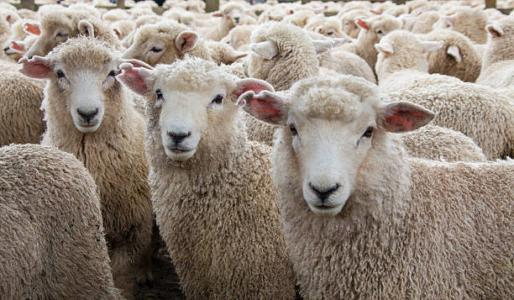

In [2]:
# Sheep - 13
# 14
img_id = 13

transform = transforms.Compose([
    transforms.Scale(300),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
base_dream_path = './deepdream/data/target/'

# transform = transforms.Compose([transforms.Scale((224,224)),transforms.ToTensor()])

dream_set = dset.ImageFolder(base_dream_path,transform=transform)

dset_loader = torch.utils.data.DataLoader(dream_set, batch_size=1)
inputs = dset_loader.dataset[img_id][0].unsqueeze(0)
input_np = inputs.numpy()

# inputs, classes = next(iter(dset_loader))
# input_np = inputs.numpy()

ddutil.showtensor(input_np)

# base_image = Image.fromarray(np.uint8(input_np * 255)).convert('RGBA')
# plt.imshow(base_image)

In [3]:
# model = models.inception_v3(pretrained=True)
# os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'

# load the model

model = ddresnet.resnet50(pretrained=True)

model.cuda()
# model = torch.nn.DataParallel(model, device_ids=[0, 1])
for param in model.parameters():
    param.require_grads = False

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:11<00:00, 8693164.58it/s]


In [4]:
model.layer3[3]

Bottleneck (
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
)

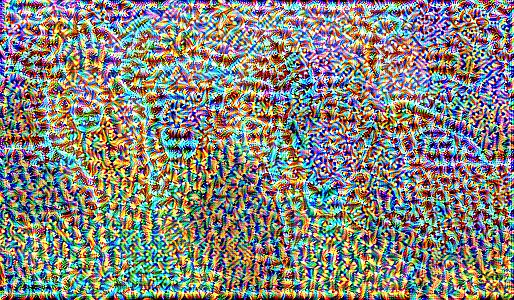

In [32]:
# deep dream
#3,5,.2,10,5,1
dream(model, input_np, 
          octave_n=1, 
          num_iterations=50, 
          lr=.35,
          max_jitter=0,
          show_every=2,
          end_layer=1)

In [880]:
# showtensor(scipy.ndimage.rotate(Image.fromarray(test), 5, reshape=False))

In [10]:
'''Other functionality to add
1. rotate images
2. circle cropping of images
3. rain drop cropping
'''
# maybe use pytorch instead: https://github.com/pytorch/pytorch/issues/2845
import numpy as np
import torch
from deepdream.util import showtensor, streamtensor
import scipy.ndimage as nd
from torch.autograd import Variable
import scipy

import random

def resize(img,h_scale,w_scale):
    img = scipy.ndimage.zoom(img[0], (1,h_scale,w_scale))
    img = np.expand_dims(img, axis=0)
    return img

def crop_zoom(img,zoom_interval,zoom_orientation):
    h,w = img.shape[-2:]
    
    if zoom_orientation=='center':
        img = img[:,:,zoom_interval:-zoom_interval,zoom_interval:-zoom_interval]
    elif zoom_orientation=='left':
        img = img[:,:,zoom_interval:-zoom_interval,0:-zoom_interval]
    elif zoom_orientation=='strings':
        img = img[:,:,zoom_interval:-zoom_interval,0:zoom_interval]
    #elif zoom_orientation=='random':
        # ZeroDivisionError: division by zero
        #img = img[:,:,zoom_interval:-random.randint(0,zoom_interval),zoom_interval:-random.randint(0,zoom_interval)]
    elif zoom_orientation=='sin':
        try:
            i += 1
        except:
            i = 0
            sin_range = [i for i in np.arange(0,zoom_interval,.1)]
            
        zi = int(abs(np.sin(i)*100))*10
        if zi <= 0:
            zi = 1
        img = img[:,:,zi:-zi,zi:-zi]
    #elif zoom_orientation=='rotate':
        #img = scipy.ndimage.rotate(img, 5, reshape=False)
    else:
        img = img[:,:,zoom_interval:-zoom_interval,zoom_interval:-zoom_interval]
        
    h_scale = h/img.shape[2]
    w_scale = w/img.shape[3]
    img = resize(img,h_scale,w_scale)
    return img


def objective_L2(dst, guide_features):
    return dst.data


def zoom_step(X, model,use_gpu=True,stream_out=False, **kwargs):
    #     X = X.copy()

    mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
    std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])

    learning_rate = kwargs.pop('lr', 5.0)
    max_jitter = kwargs.pop('max_jitter', 100)
    num_iterations = kwargs.pop('num_iterations', 100)
    show_every = kwargs.pop('show_every', 25)
    end_layer = kwargs.pop('end_layer', 3)
    object = kwargs.pop('objective', objective_L2)
    guide_features = kwargs.pop('guide_features', None)
    # print(end_layer)
    
    for t in range(num_iterations):
        ox, oy = np.random.randint(-max_jitter, max_jitter + 1, 2)
        X = np.roll(np.roll(X, ox, -1), oy, -2)

        model.zero_grad()
        X_tensor = torch.Tensor(X)
        
        if use_gpu: X_Variable = Variable(X_tensor.cuda(), requires_grad=True)
        else: X_Variable = Variable(X_tensor.cpu(), requires_grad=True)

        act_value = model.forward(X_Variable, end_layer)
        diff_out = object(act_value, guide_features)
        act_value.backward(diff_out)

        learning_rate_ = learning_rate / np.abs(X_Variable.grad.data.cpu().numpy()).mean()

        X_Variable.data.add_(X_Variable.grad.data * learning_rate_)
        X = X_Variable.data.cpu().numpy()
        X = np.roll(np.roll(X, -ox, -1), -oy, -2)
        X[0, :, :, :] = np.clip(X[0, :, :, :], -mean / std, (1. - mean) / std)
   
        if stream_out:
            if t == 0 or (t + 1) % show_every == 0:
                streamtensor(X)
            
    return X

def zoom_dream(model, base_img, zoom_depth=20,zoom_interval=10,zoom_orientation='center',fade_alpha=.3,
               octave_n=4, octave_scale=1.4, end='', use_gpu=True,stream_out=False,zoom_echo=False,
               awaken=False, awaken_alpha=0.1,**step_params):
    
    root_img = base_img.copy()
    streamtensor(root_img)
    #streamtensor(resize(root_img,3,3))
    
    mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
    std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])
    octaves = [base_img]
    for i in range(octave_n - 1):
        octaves.append(nd.zoom(octaves[-1], (1, 1, 1.0 / octave_scale, 1.0 / octave_scale), order=1))

    detail = np.zeros_like(octaves[-1])
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1, 1.0 * h / h1, 1.0 * w / w1), order=1)

        base_img = octave_base + detail

        for i in range(0,zoom_depth):
            
            if zoom_echo:
                streamtensor(base_img)
                
            base_img = zoom_step(base_img, model, **step_params,use_gpu=use_gpu,stream_out=stream_out)
            
            #streamtensor(resize(base_img,3,3))
            streamtensor(base_img)
            base_img = crop_zoom(base_img,zoom_interval,zoom_orientation) * (1.0 - fade_alpha) + base_img * fade_alpha
            
            if awaken:
                if not i % 20:
                    base_img = crop_zoom(base_img,zoom_interval,zoom_orientation) * (1.0 - awaken_alpha) + awaken_alpha * root_img
                    #prior_img = base_img.copy()
                #if i % 2:
                    # interesting effect: root_img * prior_img, instead of awaken_alpha * prior_img
                    #base_img = crop_zoom(base_img,zoom_interval,zoom_orientation) * (1.0 - awaken_alpha) + awaken_alpha * prior_img
                    #base_img = crop_zoom(base_img,zoom_interval,zoom_orientation) * (1.0 - awaken_alpha) + awaken_alpha * root_img

            #if not i % 2:
            #        prior_img = base_img.copy()
            #base_img = crop_zoom(base_img,zoom_interval,zoom_orientation) * (1.0 - awaken_alpha) + awaken_alpha * prior_img

            # regular zoom
            #base_img = crop_zoom(base_img,zoom_interval,zoom_orientation)

In [11]:
'''Going to need to convert this to tensor'''
# # from PIL import Image
# import requests
# from io import BytesIO

# url='https://pbs.twimg.com/media/DVlGsBjUQAA9qVe.jpg:large'
# response = requests.get(url)
# url_img = Image.open(BytesIO(response.content))

'Going to need to convert this to tensor'

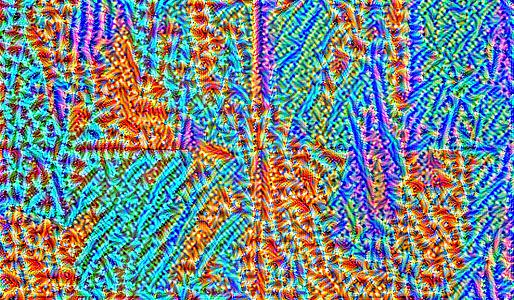

KeyboardInterrupt: 

In [33]:
# !DO NOT REMOVE BELOW!
#------------------!!!-------------------------!!!----------------------------!!!----------------------------

##
# Sheep 13
##

# Below assumes an image with max 500px width
dream_dict = {}
dream_dict['brain_coral'] = {'zoom_interval':200,'zoom_orientation':'strings','fade_alpha':0.3,'octave_n':1,
                             'num_iterations':2,'lr':0.2,'max_jitter':0,'show_every':1,'end_layer':1,
                             'stream_out':False,'zoom_echo':False,'awaken':False,'awaken_alpha':0.0}
dream_dict['objects_zoom'] = {'zoom_interval':20,'zoom_orientation':'center','fade_alpha':0,'octave_n':1,
                             'num_iterations':5,'lr':0.1,'max_jitter':0,'show_every':1,'end_layer':3,
                              'stream_out':False,'zoom_echo':False,'awaken':False,'awaken_alpha':0.0}

# Below assumes an image with max 250px width
dream_dict['futurama'] = {'zoom_interval':50,'zoom_orientation':'center','fade_alpha':0.01,'octave_n':1,
                      'num_iterations':4,'lr':0.41,'max_jitter':0,'show_every':1,'end_layer':3,
                      'stream_out':False,'zoom_echo':True,'awaken':False,'awaken_alpha':0.2}
dream_dict['fast_animal_flight'] = {'zoom_interval':30,'zoom_orientation':'center','fade_alpha':0.01,'octave_n':1,
                      'num_iterations':2,'lr':0.18,'max_jitter':0,'show_every':1,'end_layer':3,
                      'stream_out':False,'zoom_echo':False,'awaken':False,'awaken_alpha':0.12}

##
# Sheep 15
##

# Assume image was 250px width max
dream_dict['color_tunnel'] = {'zoom_interval':30,'zoom_orientation':'center','fade_alpha':0.1,'octave_n':1,
                      'num_iterations':1,'lr':0.18,'max_jitter':0,'show_every':1,'end_layer':1,
                      'stream_out':False,'zoom_echo':False,'awaken':False,'awaken_alpha':0.5}

#------------------!!!-------------------------!!!----------------------------!!!----------------------------
# !DO NOT REMOVE ABOVE!

#NOTES

# zoom_orientation 'strings' 
# Vertical banding: higher zoom interval (with (dim/2 - 1) as max) produces more vertical
# Horizontal banding: lower zoom interval produces more horizontal

#max_width = 200

dream_dict['test'] = {'zoom_interval':20,'zoom_orientation':'center','fade_alpha':0.01,'octave_n':1,
                      'num_iterations':15,'lr':0.18,'max_jitter':0,'show_every':1,'end_layer':1,
                      'stream_out':False,'zoom_echo':False,'awaken':False,'awaken_alpha':0.5}


dict_target = 'test'

zoom_dream(model, input_np, 
           zoom_depth=350,
           zoom_interval=dream_dict[dict_target]['zoom_interval'],
           zoom_orientation=dream_dict[dict_target]['zoom_orientation'],
           fade_alpha=dream_dict[dict_target]['fade_alpha'],
           octave_n=dream_dict[dict_target]['octave_n'], 
           num_iterations=dream_dict[dict_target]['num_iterations'], 
           lr=dream_dict[dict_target]['lr'],
           max_jitter=dream_dict[dict_target]['max_jitter'],
           show_every=dream_dict[dict_target]['show_every'],
           end_layer=dream_dict[dict_target]['end_layer'],
           stream_out=dream_dict[dict_target]['stream_out'],
           zoom_echo=dream_dict[dict_target]['zoom_echo'],
           awaken=dream_dict[dict_target]['awaken'],
           awaken_alpha=dream_dict[dict_target]['awaken_alpha']
          )


In [824]:
np.sin(7.5)

0.9379999767747389

In [797]:
# # from PIL import Image
# import requests
# from io import BytesIO

# url='https://twitter.com/search?q=%2399fridays&src=typd'
# response = requests.get(url)
# url_img = Image.open(BytesIO(response.content))

In [453]:
# resize_tuple = test.shape[-2:]
h,w = test.shape[-2:]
print(resize_tuple)
print(test.shape)
test_crop = test[:,:,0:-10, 0:-10]
print(test_crop.shape)

h_scale = h/test_crop.shape[2]
# w_scale = w/test_crop.shape[3]

# print(np.roll(test_crop[0].shape,2))
test_resized = scipy.ndimage.zoom(test_crop[0], (h_scale,w_scale,1))
test_resized = np.expand_dims(test_resized, axis=0)
test_resized.shape

# showtensor(test_resized)

(357, 612)
(1, 3, 357, 612)
(1, 3, 347, 602)


/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


(1, 3, 353, 602)

In [411]:
w/test_crop.shape[3]

1.0166112956810631

In [414]:
round((612/602)*602)

612

In [459]:
def resize(img,h_scale,w_scale):
    img = scipy.ndimage.zoom(img[0], (1,h_scale,w_scale))
    img = np.expand_dims(img, axis=0)
    return img

def crop_zoom(img):
    h,w = img.shape[-2:]
    img = img[:,:,0:-10,0:-10]
    h_scale = h/img.shape[2]
    w_scale = w/img.shape[3]
    img = resize(img,h_scale,w_scale)
    return img

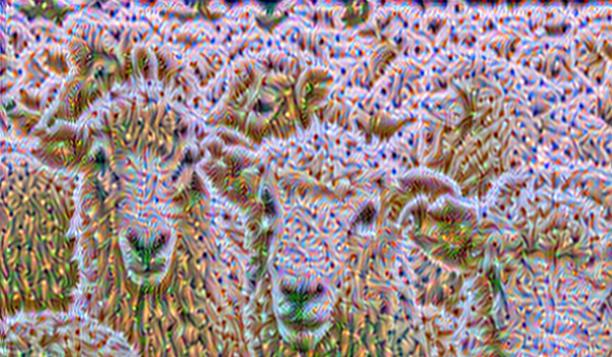

In [477]:
for i in range(0,20):
    # print(test.shape)
    test_crop = crop_zoom(test_crop)
    # print(test_crop.shape)
    showtensor(test_crop)

In [314]:
test_resized/100

array([[[[ 1.73,  1.76,  1.77, ...,  1.73,  1.85,  1.86],
         [ 1.68,  1.77,  1.84, ...,  1.81,  1.94,  1.93],
         [ 1.7 ,  1.79,  1.92, ...,  1.88,  1.93,  1.91],
         ..., 
         [ 1.11,  0.66,  0.69, ...,  1.17,  0.89,  1.06],
         [ 0.97,  0.63,  0.74, ...,  1.02,  0.76,  0.86],
         [ 0.83,  0.66,  0.81, ...,  1.03,  0.65,  0.56]],

        [[ 1.66,  1.67,  1.66, ...,  1.74,  1.67,  1.68],
         [ 1.68,  1.77,  1.8 , ...,  1.83,  1.81,  1.78],
         [ 1.73,  1.82,  1.93, ...,  1.97,  1.94,  1.88],
         ..., 
         [ 1.  ,  0.53,  0.61, ...,  1.13,  0.85,  0.97],
         [ 0.91,  0.53,  0.67, ...,  0.96,  0.68,  0.79],
         [ 0.83,  0.64,  0.78, ...,  0.94,  0.55,  0.48]],

        [[ 1.68,  1.67,  1.65, ...,  1.72,  1.65,  1.64],
         [ 1.72,  1.77,  1.77, ...,  1.85,  1.8 ,  1.75],
         [ 1.79,  1.86,  1.98, ...,  2.01,  1.96,  1.91],
         ..., 
         [ 1.06,  0.58,  0.65, ...,  1.15,  0.86,  0.96],
         [ 1.01,  0.61,

In [ ]:
# To do:
# Update with model with more layers
# figure out how to activate specific neurons
# you need to draw to screen until cancel while being
# if you can do the above can you adjust which layer you're using at run

# Control the dream

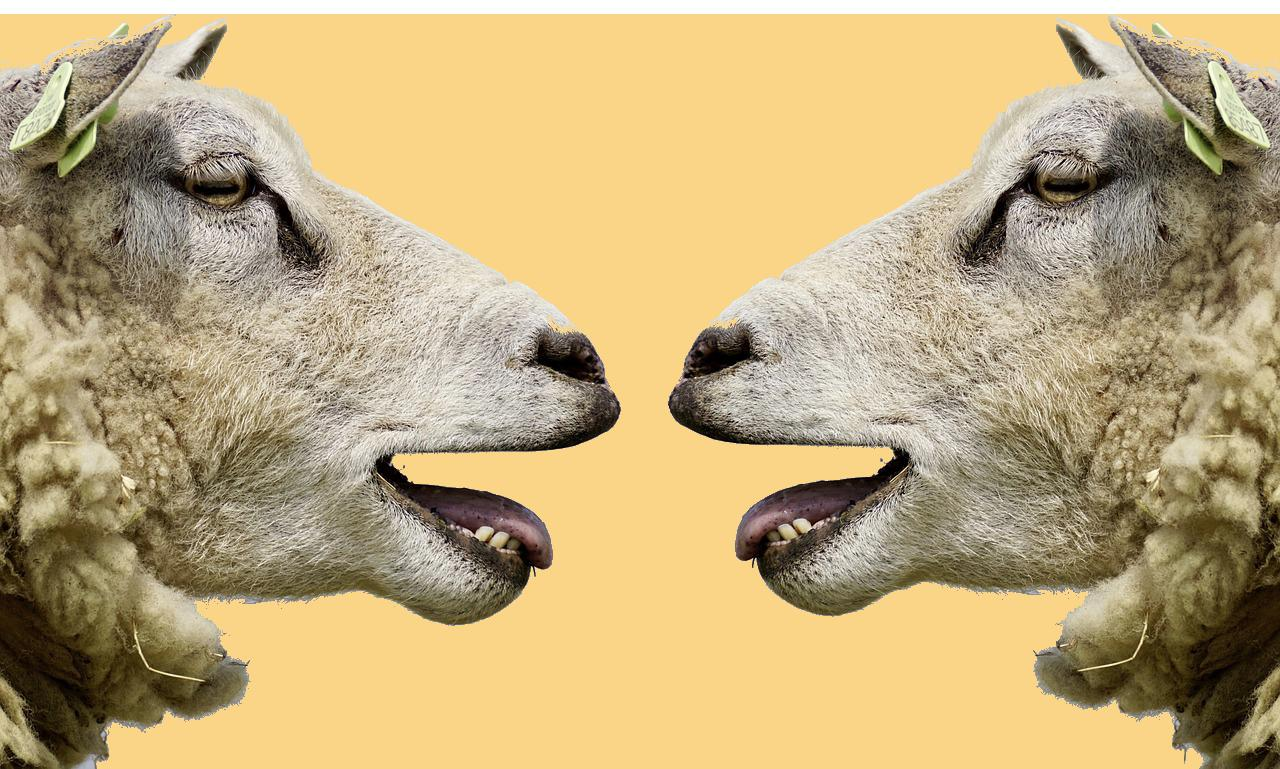

In [38]:
img_id = 14
base_dream_path = './deepdream/data/target/'

# transform = transforms.Compose([
#     transforms.Scale((425,425)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#     ])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])


# transform = transforms.Compose([transforms.Scale((224,224)),transforms.ToTensor()])

dream_set = dset.ImageFolder(base_dream_path,transform=transform)
# dset = datasets.ImageFolder(os.path.join(), transforms)
dset_loader = torch.utils.data.DataLoader(dream_set, batch_size=1)
inputs_guide = dset_loader.dataset[img_id][0].unsqueeze(0)
inputs_guide_np = inputs_guide.numpy()

#inputs_guide, classes_guide = next(iter(dset_loader))
#inputs_guide_np = inputs_guide.numpy()

ddutil.showtensor(inputs_guide_np)

# base_image = Image.fromarray(np.uint8(input_np * 255)).convert('RGBA')
# plt.imshow(base_image)

In [8]:
model = ddresnet.resnet50(pretrained=True)

In [ ]:
# print(model.fc)
# total_classes = 2000
# model.fc = nn.Linear(model.fc.in_features, total_classes) # Our dataset has 2 classes
# print(model.fc)

In [ ]:
#model = models.resnet18(pretrained=True)

In [9]:
model.cuda()
# model = torch.nn.DataParallel(model, device_ids=[0, 1]).cuda()
for param in model.parameters():
    param.require_grads = False

X_Variable = Variable(inputs_guide.cuda())
guide_features = model.forward(X_Variable, n_layer=3)

In [10]:
def objective_guide(dst, guide_features):
#     print(1)
    x = dst.data[0].cpu().numpy().copy()
#     print(type(dst), dst.size(), dst)
#     print(type(guide_features))
    y = guide_features.data[0].cpu().numpy()
#     print(dst.size())
    ch, w, h = x.shape
    x = x.reshape(ch,-1)      # (c，w*h)
    y = y.reshape(ch,-1)      # (c, w*h)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    result = y[:,A.argmax(1)] # select ones that match best
    result = torch.Tensor(np.array([result.reshape(ch, w, h)], dtype=np.float)).cuda()
#     print(type(result), result.size(), result)
    return result

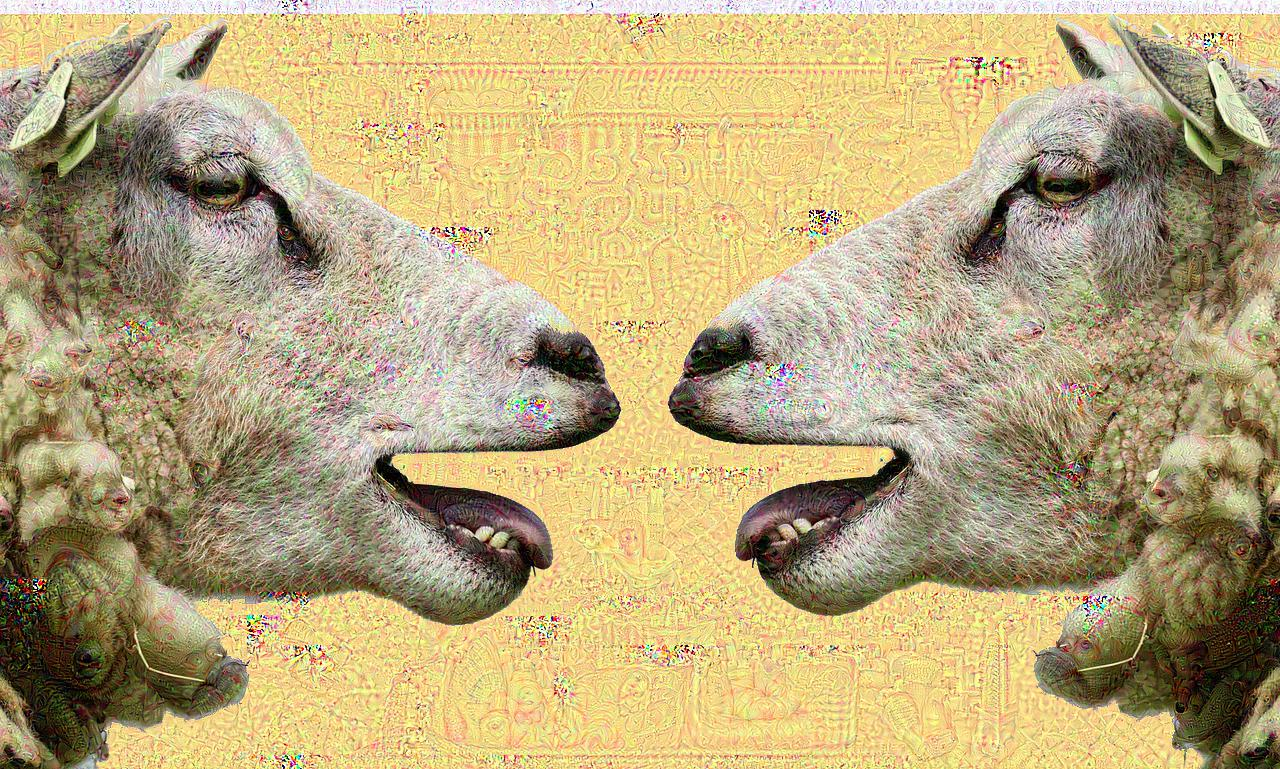

In [55]:
dream(model, input_np, 
      octave_n=1,
      num_iterations=20, 
      lr=.05,
      max_jitter=1000,
      show_every=1,
      end_layer=3,
      octave_scale=1.4,
      objective=objective_guide,
      guide_features=guide_features)

In [ ]:
# you should keep every step, record
# In the cauldron

Model that builds data structures by itself and organizes images in it. This runs in real time and is visualized in real time.

In [ ]:
# Gift GHIF Jiff image 